# Time series analysis on AWS
*Chapter 9 - Creating a dataset and ingesting your data*

## Initializations
---

In [1]:
!pip install --quiet tqdm kaggle

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Imports

In [1]:
import matplotlib.colors as mpl_colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import warnings
import zipfile

from matplotlib import gridspec
from sklearn.preprocessing import normalize
from tqdm import tqdm
from urllib.request import urlretrieve

### Parameters

In [2]:
RAW_DATA = os.path.join('..', 'Data', 'raw')
DATA = os.path.join('..', 'Data')
warnings.filterwarnings("ignore")
os.makedirs(RAW_DATA, exist_ok=True)

%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 0.3
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['legend.fontsize'] = 5

### Helper functions

In [3]:
def progress_report_hook(count, block_size, total_size):
    mb = int(count * block_size // 1048576)
    if count % 500 == 0:
        sys.stdout.write("\r{} MB downloaded".format(mb))
        sys.stdout.flush()

### Downloading datasets

#### **Dataset 4:** Industrial pump data
To download this dataset from Kaggle, you will need to have an account and create a token that you install on your machine. You can follow [**this link**](https://www.kaggle.com/docs/api) to get started with the Kaggle API. Once generated, make sure your Kaggle token is stored in the `~/.kaggle/kaggle.json` file, or the next cells will issue an error. To get a Kaggle token, go to kaggle.com and create an account. Then navigate to **My account** and scroll down to the API section. There, click the **Create new API token** button:

<img src="../Assets/kaggle_api.png" />


In [4]:
FILE_NAME    = 'pump-sensor-data.zip'
ARCHIVE_PATH = os.path.join(RAW_DATA, FILE_NAME)
FILE_PATH    = os.path.join(DATA, 'pump', 'sensor.csv')
FILE_DIR     = os.path.dirname(FILE_PATH)

if not os.path.isfile(FILE_PATH):
    if not os.path.exists('/home/ec2-user/.kaggle/kaggle.json'):
        os.makedirs('/home/ec2-user/.kaggle/', exist_ok=True)
        raise Exception('The kaggle.json token was not found.\nCreating the /home/ec2-user/.kaggle/ directory: put your kaggle.json file there once you have generated it from the Kaggle website')
    else:
        print('The kaggle.json token file was found: making sure it is not readable by other users on this system.')
        !chmod 600 /home/ec2-user/.kaggle/kaggle.json

    os.makedirs(os.path.join(DATA, 'pump'), exist_ok=True)
    !kaggle datasets download -d nphantawee/pump-sensor-data -p $RAW_DATA

    print("\nExtracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
else:
    print("File found, skipping download")

File found, skipping download


## Dataset visualization
---

### **4.** Industrial pump data

In [5]:
FILE_PATH = os.path.join(DATA, 'pump', 'sensor.csv')
pump_df = pd.read_csv(FILE_PATH, sep=',')
pump_df.drop(columns={'Unnamed: 0'}, inplace=True)
pump_df['timestamp'] = pd.to_datetime(pump_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
pump_df = pump_df.set_index('timestamp')

pump_df['machine_status'].replace(to_replace='NORMAL', value=np.nan, inplace=True)
pump_df['machine_status'].replace(to_replace='BROKEN', value=1, inplace=True)
pump_df['machine_status'].replace(to_replace='RECOVERING', value=1, inplace=True)

print('Shape:', pump_df.shape)
pump_df.head()

Shape: (220320, 53)


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NaN
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NaN
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NaN
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NaN
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NaN


In [8]:
pump_df

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NaN
2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NaN
2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NaN
2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NaN
2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NaN
2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NaN
2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NaN


In [6]:
file_structure_df = pump_df.iloc[:, 0:10].resample('5D').mean()

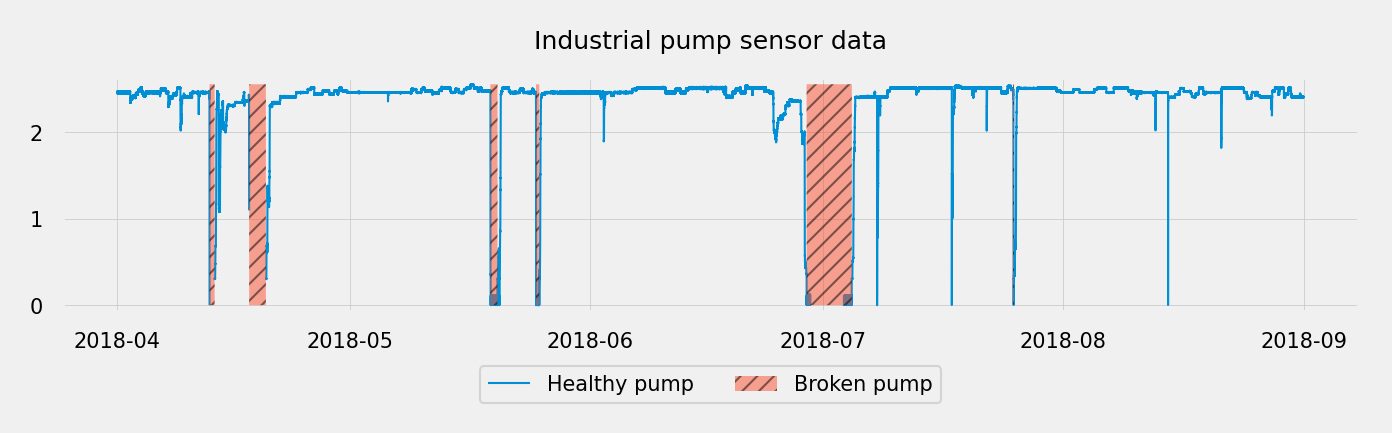

In [7]:
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.5

fig = plt.figure(figsize=(5,1))
ax1 = fig.add_subplot(1,1,1)
plot1 = ax1.plot(pump_df['sensor_00'], label='Healthy pump')

ax2 = ax1.twinx()
plot2 = ax2.fill_between(
    x=pump_df.index, 
    y1=0.0, 
    y2=pump_df['machine_status'], 
    color=colors[1], 
    linewidth=0.0,
    edgecolor='#000000',
    alpha=0.5, 
    hatch="//////", 
    label='Broken pump'
)
ax2.grid(False)
ax2.set_yticks([])

labels = [plot1[0].get_label(), plot2.get_label()]

plt.legend(handles=[plot1[0], plot2], labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -.4))
plt.title('Industrial pump sensor data')

plt.show()

In [9]:
start_date = np.min(pump_df.index)
end_date = np.max(pump_df.index)
num_periods = pump_df.shape[0]

new_index = pd.date_range(start=start_date, periods=num_periods, freq='5min')
pump_df.index = new_index
pump_df.index.name = 'Timestamp'

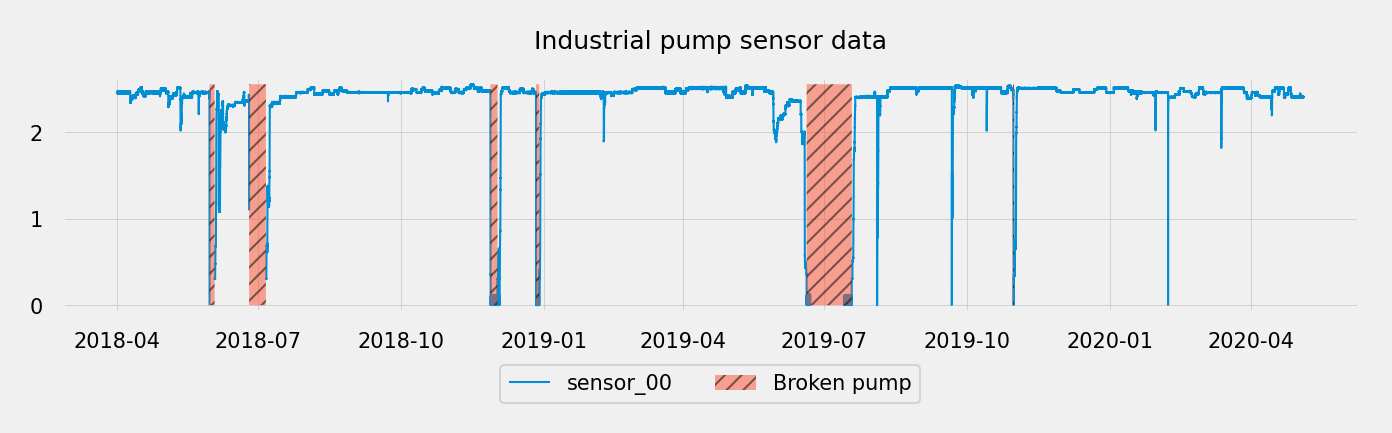

In [11]:
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 0.5

fig = plt.figure(figsize=(5,1))
ax1 = fig.add_subplot(1,1,1)
plot1 = ax1.plot(pump_df['sensor_00'], label='sensor_00')
# plot1 = ax1.plot(pump_df['sensor_34'], label='Healthy sensor_34')

ax2 = ax1.twinx()
plot2 = ax2.fill_between(
    x=pump_df.index, 
    y1=0.0, 
    y2=pump_df['machine_status'], 
    color=colors[1], 
    linewidth=0.0,
    edgecolor='#000000',
    alpha=0.5, 
    hatch="//////", 
    label='Broken pump'
)
ax2.grid(False)
ax2.set_yticks([])

labels = [plot1[0].get_label(), plot2.get_label()]

plt.legend(handles=[plot1[0], plot2], labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -.4))
plt.title('Industrial pump sensor data')

# start = pd.to_datetime('2018-06-24 14:25')
# end = pd.to_datetime('2018-07-06 09:40')
# plt.xlim(start, end)
plt.show()

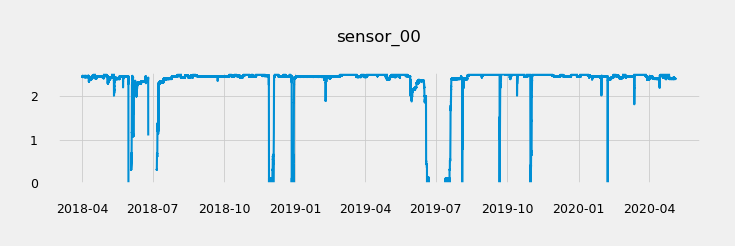

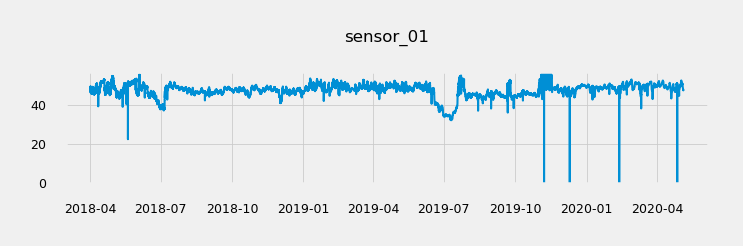

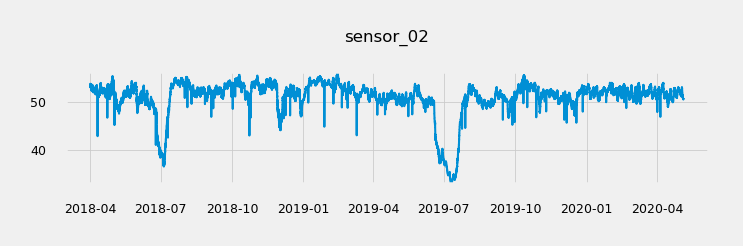

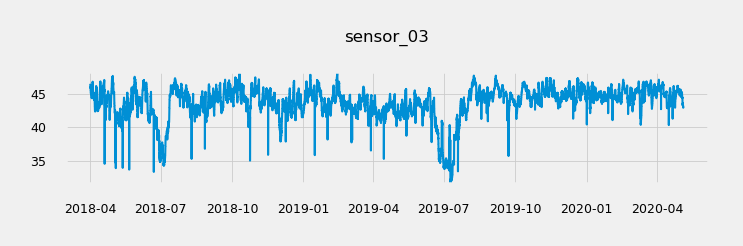

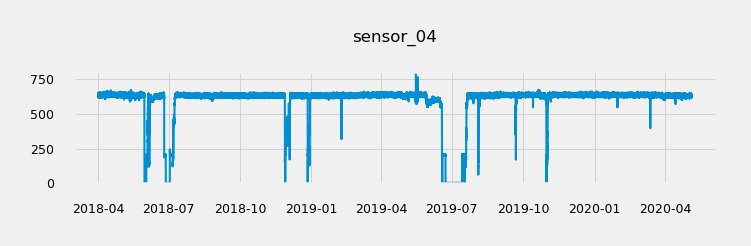

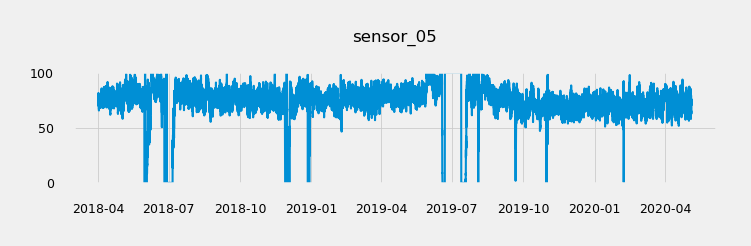

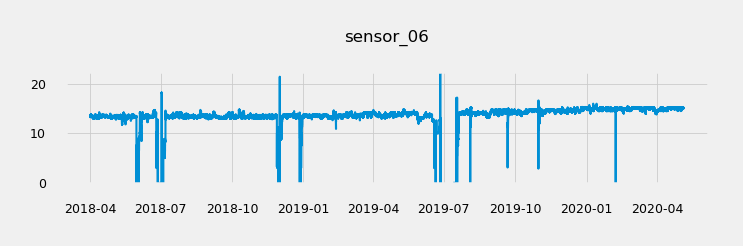

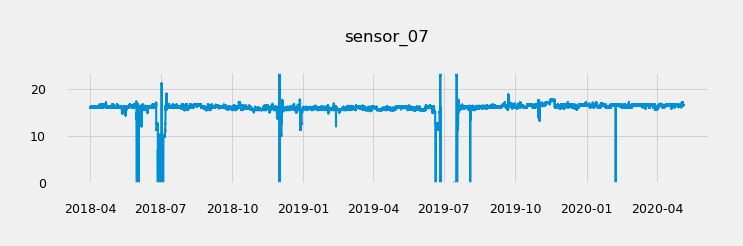

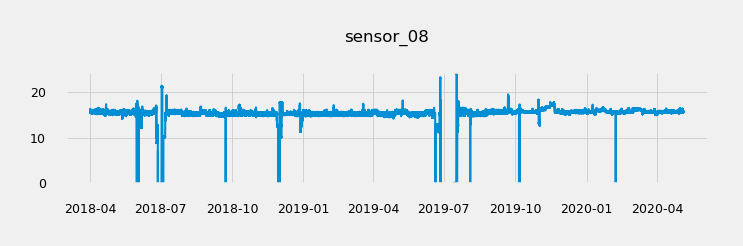

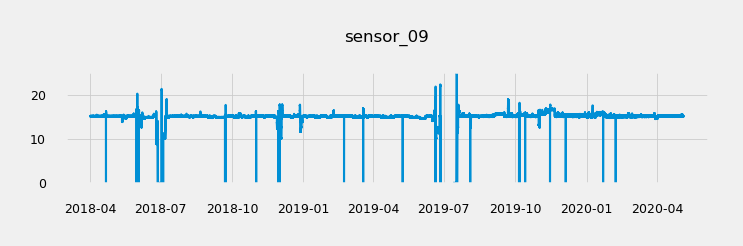

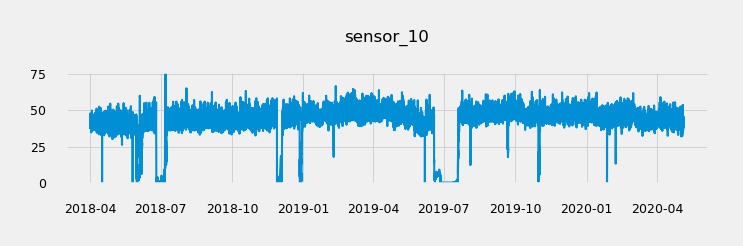

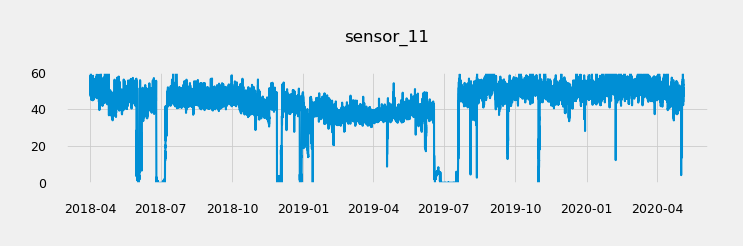

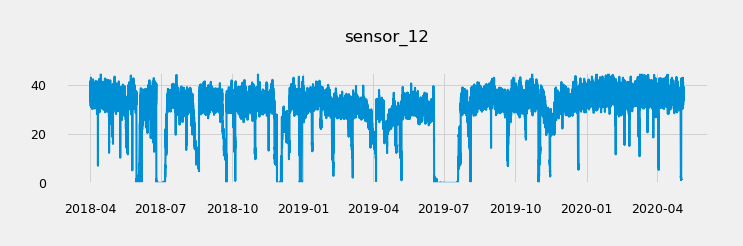

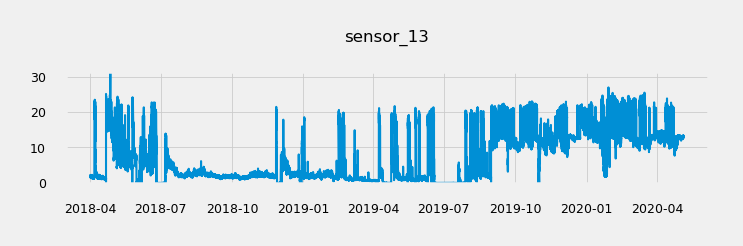

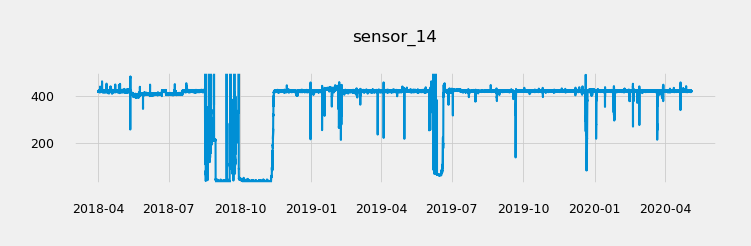

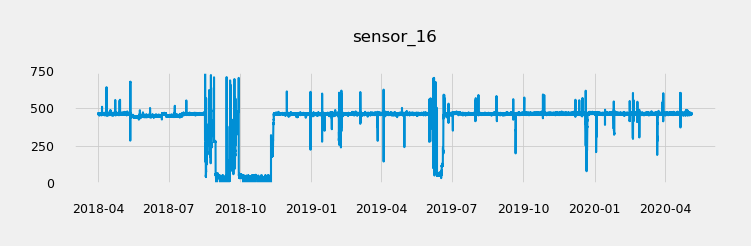

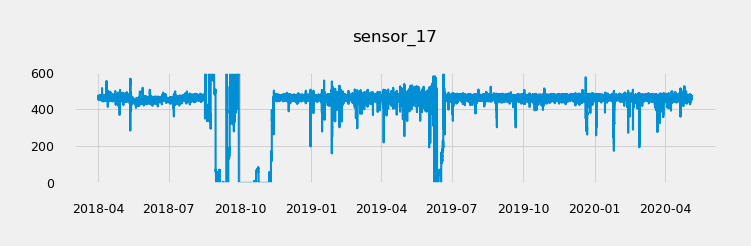

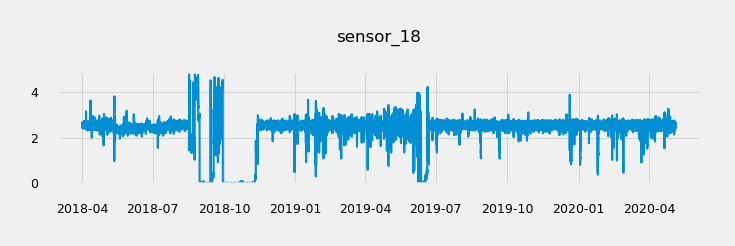

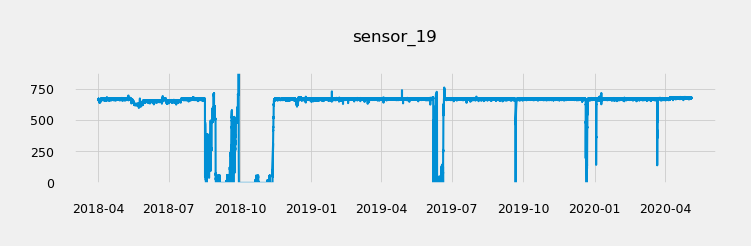

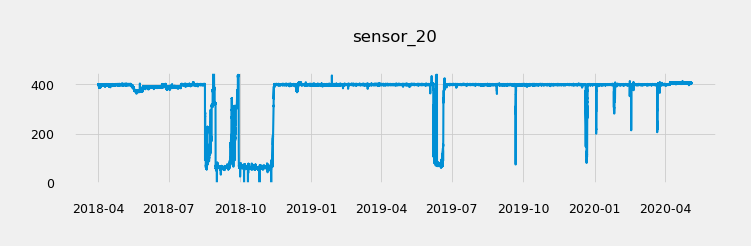

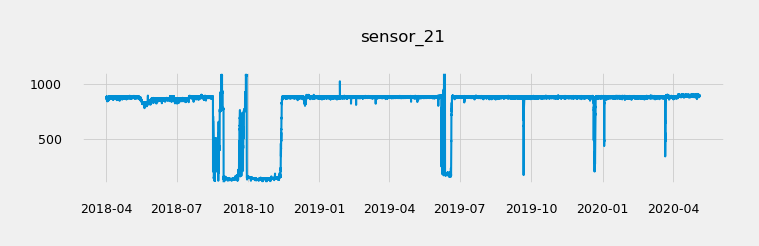

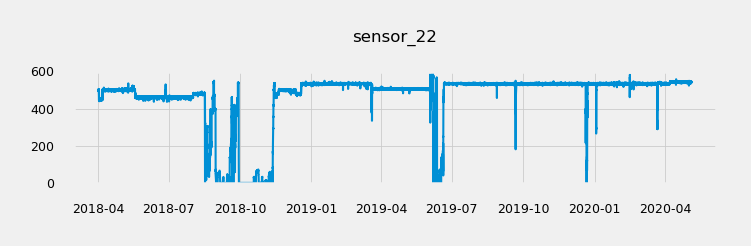

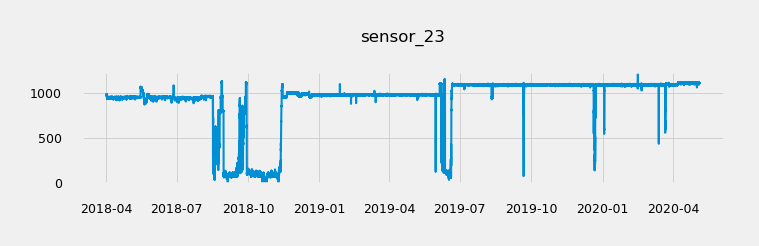

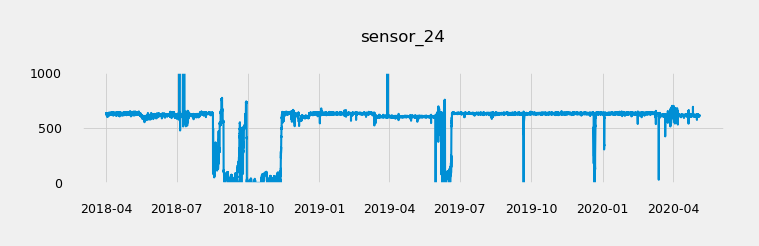

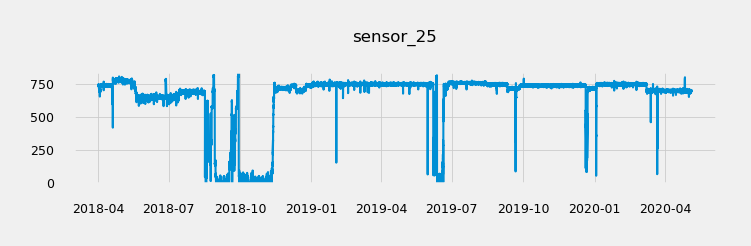

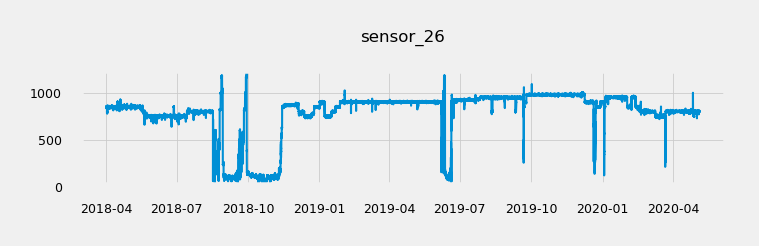

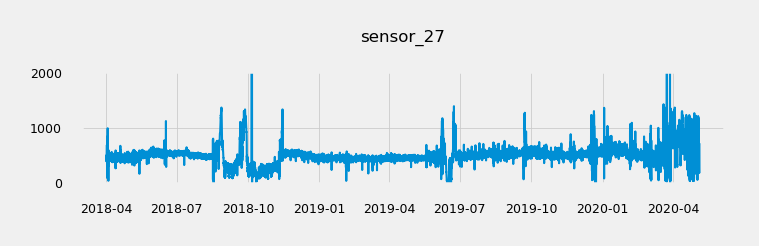

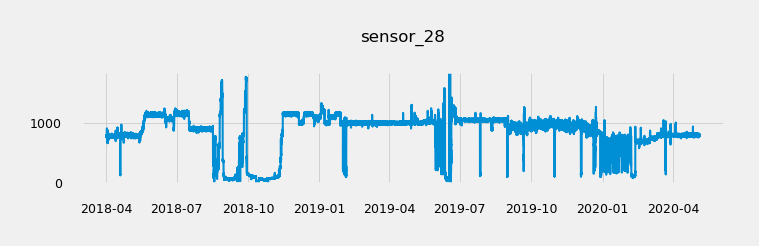

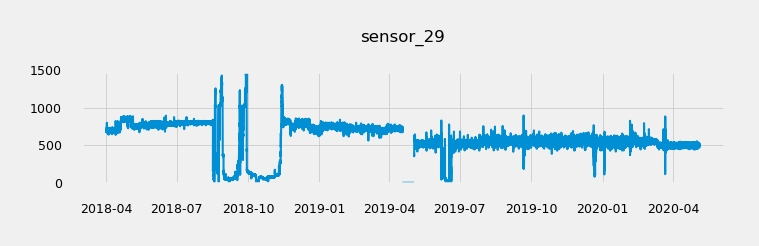

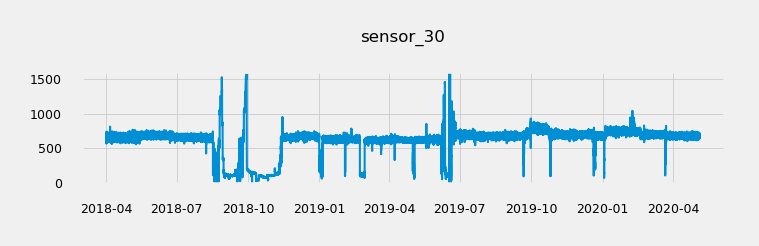

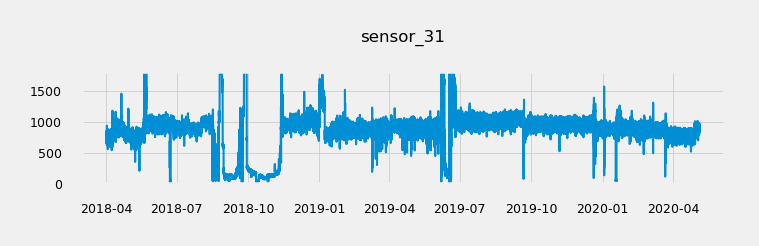

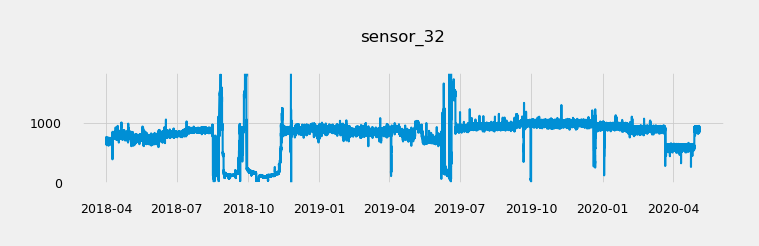

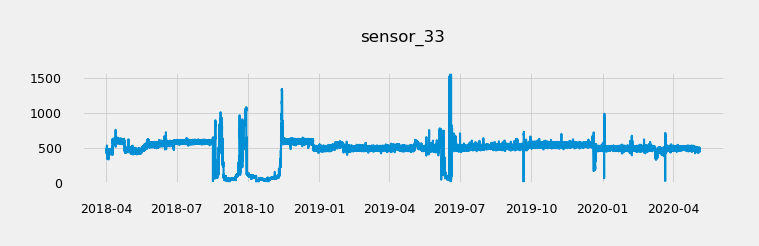

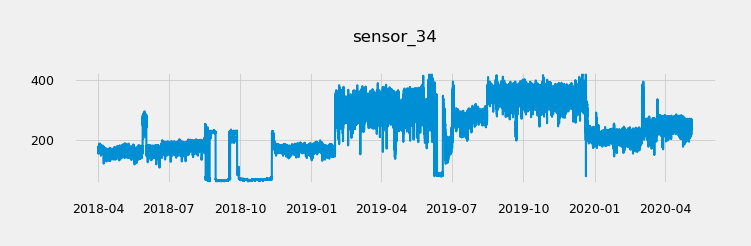

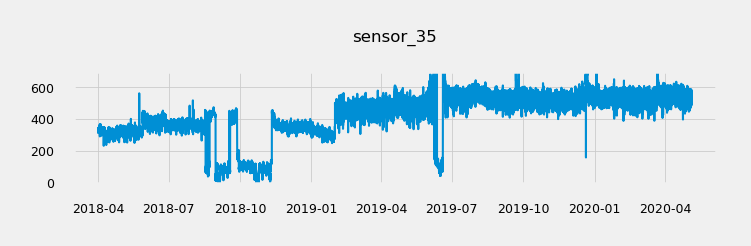

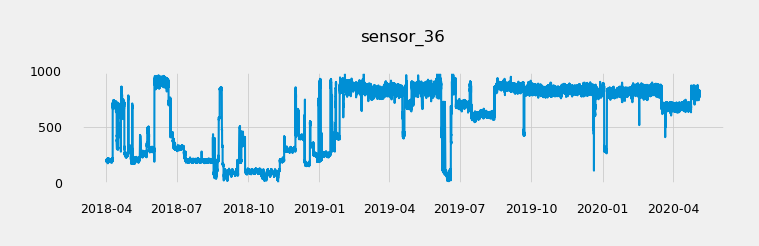

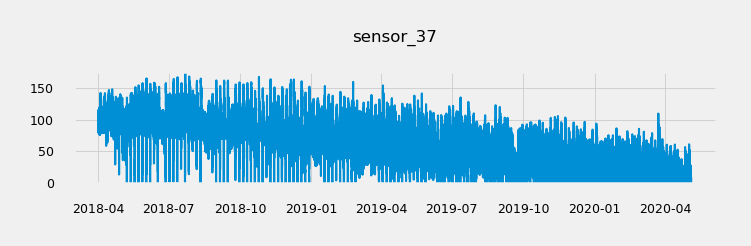

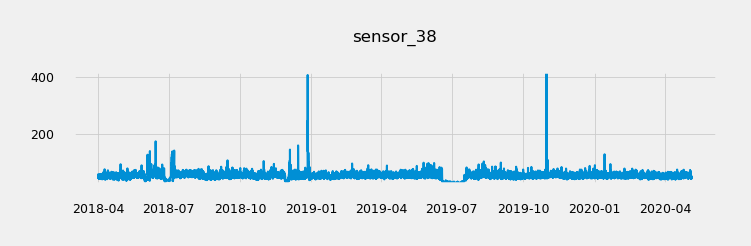

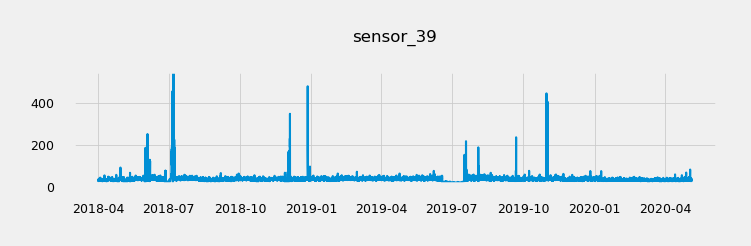

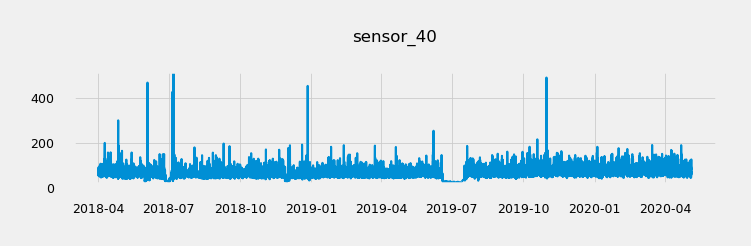

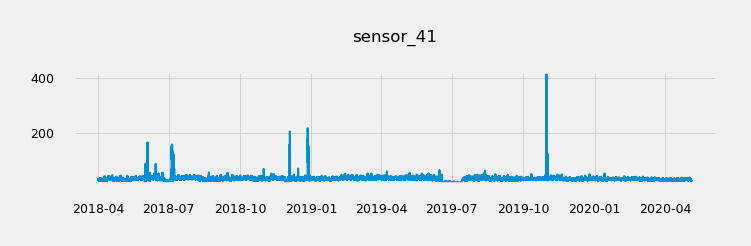

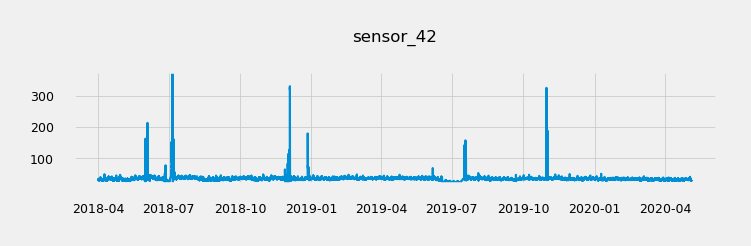

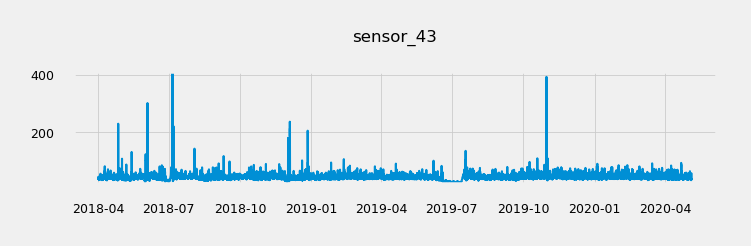

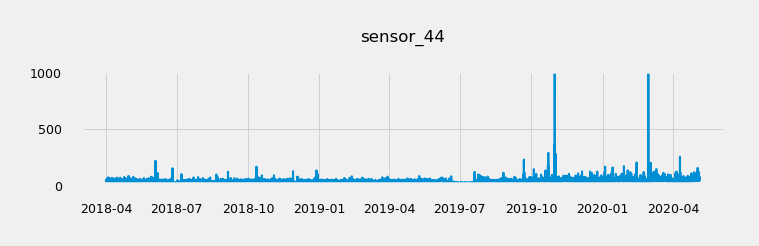

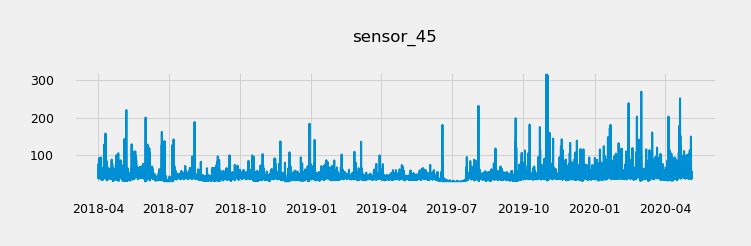

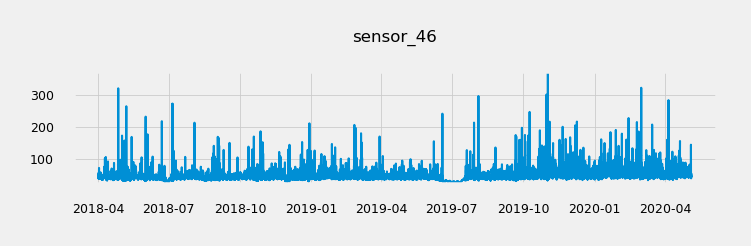

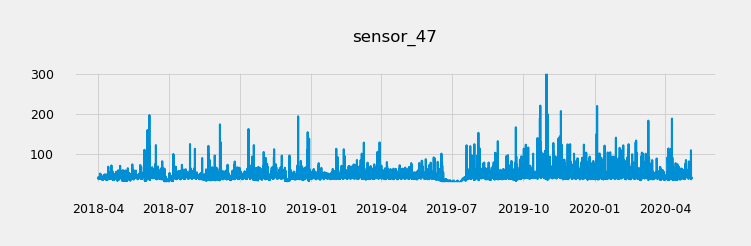

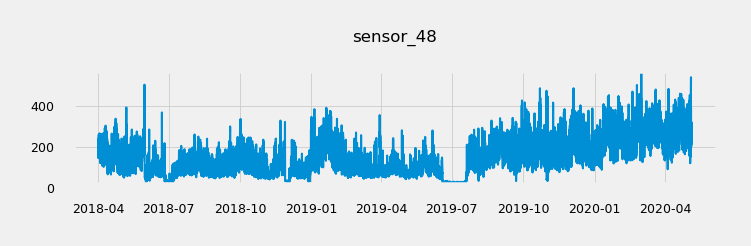

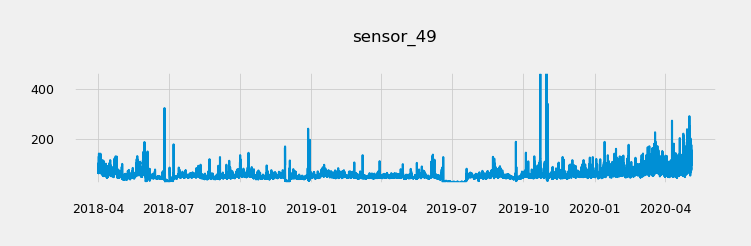

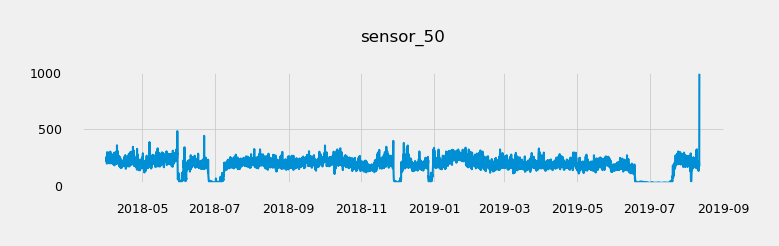

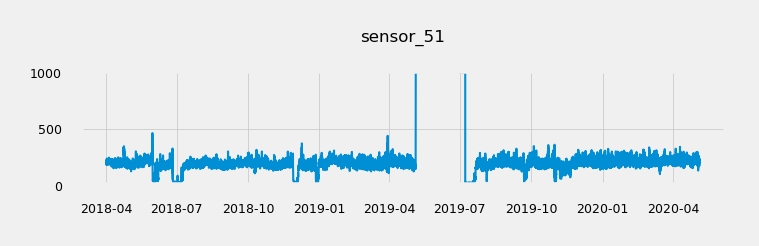

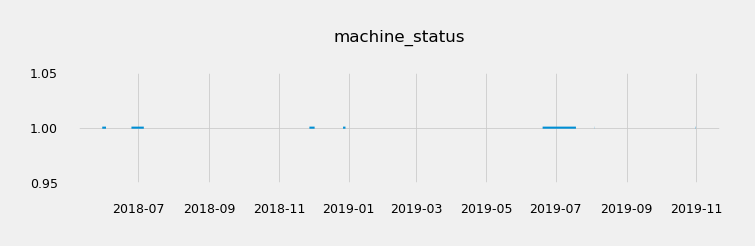

In [79]:
plt.rcParams['axes.titlesize'] = 4
plt.rcParams['axes.labelsize'] = 4
plt.rcParams['xtick.labelsize'] = 3
plt.rcParams['ytick.labelsize'] = 3

for f in list(pump_df.columns):
    fig = plt.figure(figsize=(2.5,0.5))
    ax1 = fig.add_subplot(1,1,1)
    plot1 = ax1.plot(pump_df[f])
    ax1.set_title(f)
    
plt.show()

In [12]:
pump_df = pump_df.drop(columns=['sensor_50', 'sensor_15'])

In [13]:
pump_df

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NaN
2018-04-01 00:05:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NaN
2018-04-01 00:10:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NaN
2018-04-01 00:15:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NaN
2018-04-01 00:20:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04 23:35:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,231.1921,NaN
2020-05-04 23:40:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,231.1921,NaN
2020-05-04 23:45:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,232.0602,NaN


## Preparing the dataset for Lookout for Equipment
---
### Preparing time series data

In [82]:
TRAIN_DATA = os.path.join('..', 'Data', 'pump', 'train-data')
LABEL_DATA = os.path.join('..', 'Data', 'pump', 'label-data')

os.makedirs(TRAIN_DATA, exist_ok=True)
os.makedirs(LABEL_DATA, exist_ok=True)

pump_df.index.name = 'Timestamp'

In [23]:
features = list(pump_df.columns)[:-1]

for tag in tqdm(features):
    os.makedirs(os.path.join(TRAIN_DATA, tag), exist_ok=True)
    fname = os.path.join(TRAIN_DATA, tag, 'tag_data.csv')
    tag_df = pump_df[[tag]]
    tag_df.to_csv(fname)

100%|██████████| 52/52 [00:33<00:00,  1.55it/s]


### Preparing label data

In [45]:
expanded_labels = pump_df[['machine_status']]
expanded_labels['machine_status'].unique()

array([nan,  1.])

In [105]:
from dateutil.relativedelta import relativedelta

range_df = expanded_labels.copy()
range_df['BROKEN'] = False
range_df.loc[range_df['machine_status'] == 1.0, 'BROKEN'] = True

range_df['Next Status'] = range_df['BROKEN'].shift(-1)
range_df['Start Range'] = (range_df['BROKEN'] == False) & (range_df['Next Status'] == True)
range_df['End Range'] = (range_df['BROKEN'] == True) & (range_df['Next Status'] == False)
range_df.iloc[0,3] = range_df.iloc[0,1]
range_df = range_df[(range_df['Start Range'] == True) | (range_df['End Range'] == True)]

labels_df = pd.DataFrame(columns=['start', 'end'])
for index, row in range_df.iterrows():
    if row['Start Range']:
        start = index

    if row['End Range']:
        end = index
        labels_df = labels_df.append({
            'start': start + relativedelta(hours=-12),
            'end': end + relativedelta(hours=+12)
        }, ignore_index=True)
        
labels_df

,start,end
0,2018-05-30 01:30:00,2018-06-03 08:15:00
1,2018-06-24 14:25:00,2018-07-06 09:40:00
2,2018-11-27 04:25:00,2018-12-02 17:50:00
3,2018-12-26 14:25:00,2018-12-29 16:55:00
4,2019-06-19 01:55:00,2019-07-19 05:10:00
5,2019-08-03 12:50:00,2019-08-04 16:20:00
6,2019-10-30 09:55:00,2019-10-31 16:15:00


In [106]:
from dateutil.relativedelta import relativedelta

labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
labels_df['start'] = pd.to_datetime(labels_df['start'])
labels_df['end'] = pd.to_datetime(labels_df['end'])
labels_df['start'] = labels_df['start'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')
labels_df['end'] = labels_df['end'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')
labels_df.to_csv(labels_fname, header=None, index=None)

## Creating schema
---

In [51]:
!pip install --quiet markdown

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [56]:
# Helper functions for managing Lookout for Equipment API calls:
sys.path.append('../../amazon-lookout-for-equipment-python-sdk/src')
import lookoutequipment as lookout
import sagemaker

In [57]:
DATASET_NAME = 'pump'
BUCKET       = 'pump-anomaly-detection'
PREFIX       = 'train-data/'
ROLE_ARN     = sagemaker.get_execution_role()

In [58]:
lookout_dataset = lookout.LookoutEquipmentDataset(
    dataset_name=DATASET_NAME,
    component_root_dir=TRAIN_DATA,
    access_role_arn=ROLE_ARN
)

In [63]:
lookout_dataset.dataset_schema

'{"Components": [{"ComponentName": "sensor_43", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_43", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_07", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_07", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_25", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_25", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_16", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_16", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_34", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_34", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_47", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_47", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_29", "Columns": [{"Name": "Timestamp", "Type": "DATETIME"}, {"Name": "sensor_29", "Type": "DOUBLE"}]}, {"ComponentName": "sensor_38", "Columns": [{"Name": "Timestamp", "Type": "DATETI